# Variance Reduction Techniques (Part I)

See the blog post http://blog.evjang.com/2016/09/variance-reduction-part1.html

Author: Eric Jang

9/5/2016


This notebook is written using the Julia Language.

In [2]:
using Plots

## Helper Functions

In [29]:
# empirical pearson correlation
corr(a,b) = mean((a-mean(a)).*(b-mean(b)))/(std(a)*std(b));

In [28]:
# function to empirically measure variance of estimator
function estimatorVar(estimator)
    s=zeros(50)
    for n=1:50 # for each value of n
        m=zeros(5000) # estimate 2n estimator 5000 times
        for i=1:5000
            u1,u2,x,ii=estimator(n)
            m[i]=mean(x) # monte carlo estimator
        end
        s[n]=var(m)
    end
    return s
end;

## Target Function


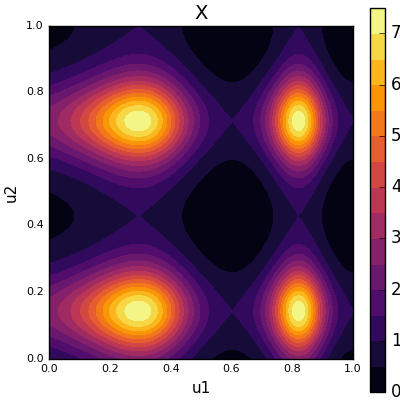

In [7]:
f(x,y) = exp(sin(8x.^2+3x)+sin(11y))
p0 = plot(linspace(0,1,100),linspace(0,1,100),f,
        st=:contourf,title="X",size=(400,400),xlabel="u1",ylabel="u2")

In [8]:
png("function.png")

## Plain Monte Carlo


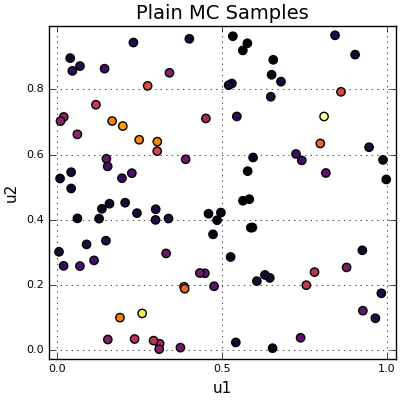

In [35]:
N=50
function plainMC(N)
    u1 = rand(2*N)
    u2 = rand(2*N)
    return u1,u2,f(u1,u2),[]
end
u1,u2,x,ii=plainMC(N)
scatter(u1,u2,markercolor=x,
        xlabel="u1",ylabel="u2",
        title="Plain MC Samples",
        size=(400,400),label="")

In [36]:
png("plain_mc")

In [38]:
# approximate ground truth of sigma_X
u1,u2,x,ii=plainMC(10000)
σ=std(x)

1.7606933937810292


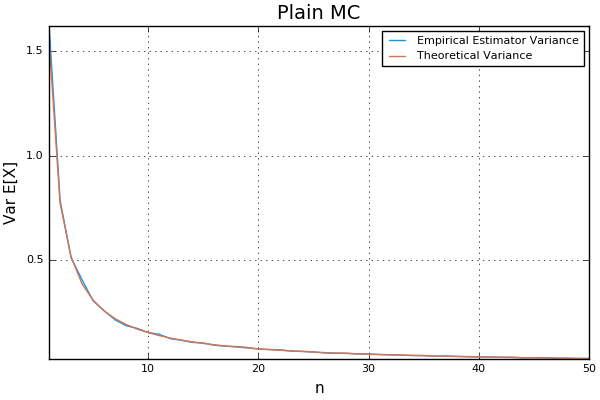

In [39]:
s = estimatorVar(plainMC)
plot(1:50,s,label="Empirical Estimator Variance",xlabel="n",ylabel="Var E[X]",title="Plain MC")
plot!(1:50,1/2*1./(1:50)*σ^2,label="Theoretical Variance")

In [40]:
png("plainMC")

## Antithetic Sampling

Each sample $X_i$ is paired with a sample that is negatively correlated to it drawn from the same distribution.

$$Var[\frac{1}{n}\sum_{i=1}^{n}{\frac{X_i+Y_i}{2}}] = \frac{1}{2n}(\sigma^2+\beta\sigma^2)$$

For $X=h(U)$, if $h$ is a linear function, then $Corr(h(U),h(1-U)) = 0$ and the variance of the antithetic estimate is zero. 


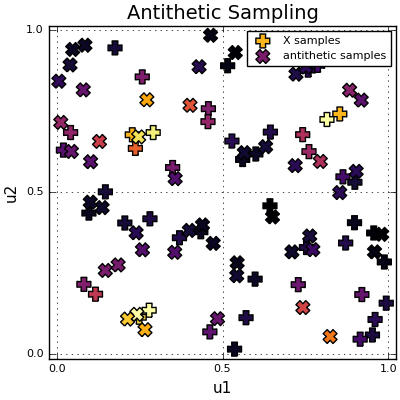

In [41]:
function antithetic(N)
    u1_x = rand(N); u2_x = rand(N);
    u1_y = 1-u1_x; u2_y = 1-u2_x;
    x = f(u1_x,u2_x);
    y = f(u1_y,u2_y);
    return [u1_x; u1_y], [u2_x; u2_y], [x;y], (u1_x,u2_x,x,u1_y,u2_y,y)
end
u1,u2,x,ii=antithetic(N)
u1_x,u2_x,x,u1_y,u2_y,y = ii
scatter(u1_x,u2_x,
        m=(10,:cross),markercolor=x,
        size=(400,400),label="X samples",
        xlabel="u1",ylabel="u2",title="Antithetic Sampling")
scatter!(u1_y,u2_y,
        m=(10,:xcross),markercolor=y,
        label="antithetic samples")

In [42]:
png("antithetic")

In [46]:
u1,u2,x,ii=antithetic(10000)
u1_x,u2_x,x,u1_y,u2_y,y = ii
β = corr(x,y)

-0.07566635559145289


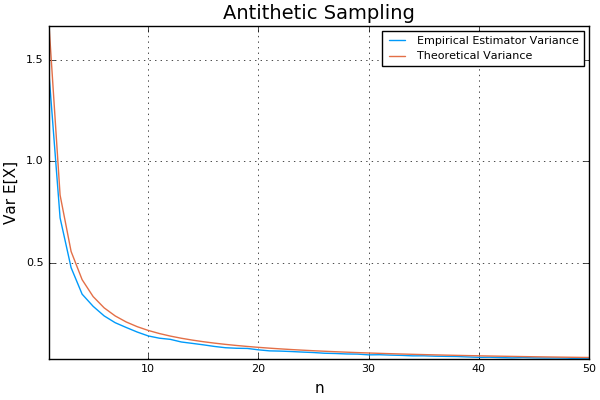

In [47]:
s = estimatorVar(antithetic)
plot(1:50,s,label="Empirical Estimator Variance",xlabel="n",ylabel="Var E[X]",title="Antithetic Sampling")
plot!(1:50,1./(2*(1:50))*σ^2*(1-β),label="Theoretical Variance")

In [41]:
png("sampling_curve")

## Control Variates


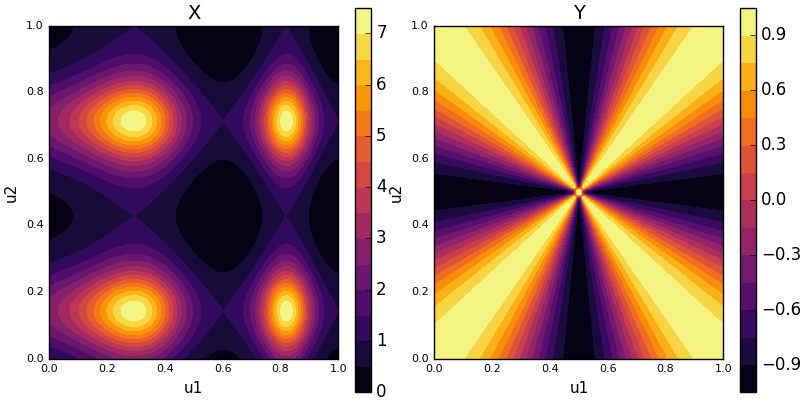

In [13]:
cv(u1,u2) = -cos(4*atan((u2-.5)./(u1-.5)))
pcv = plot(linspace(0,1,100),linspace(0,1,100),cv,st=:contourf,title="Y",xlabel="u1",ylabel="u2")
plot(p0,pcv,layout=2,size=(800,400))

In [14]:
png("cv_y")

In [109]:
function controlvariates(N)
    # generate pilot samples
    npilot = 30
    u1 = rand(npilot); u2 = rand(npilot)
    x = f(u1,u2)
    y = cv(u1,u2)
    β=corr(x,y)
    c = -β/var(y)
    μ_y = mean(y) # estimate mean from pilot samples
    # real samples
    u1 = rand(2*N); u2 = rand(2*N)
    x = f(u1,u2)
    y = cv(u1,u2)
    return u1,u2,x+c*(y-μ_y),(μ_y, β, c)
end

controlvariates (generic function with 1 method)

In [110]:
βs=[]
for i=1:1000
    u1,u2,x,ii=controlvariates(100)
    βs = [βs; ii[2]]
end
mean(βs)

0.36740503345977105

## Stratified Sampling



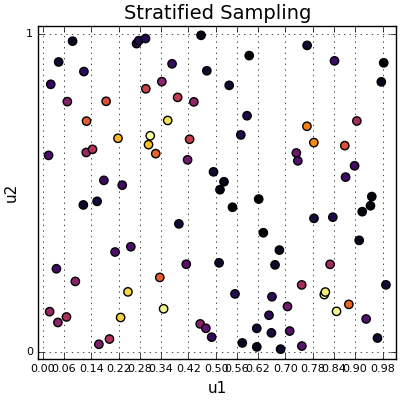

In [124]:
# we could stratify in a grid, but it's easier to illustrate in 1D
function stratified(N)
    # N strata, 2 samples per strata = 2N samples
    u1 = Float64[]
    u2 = Float64[]
    for y=range(0,1/N,N)
        for i=1:2
            append!(u1,[y+1/N*rand()])
            append!(u2,[rand()])
        end
    end
    return u1,u2,f(u1,u2),[]
end
u1,u2,x,ii=stratified(50)
scatter(u1,u2,markercolor=x,size=(400,400),xticks=range(0,1/N,N), yticks=[0,1],label="",
xlabel="u1",ylabel="u2",title="Stratified Sampling")

In [125]:
png("stratified_points")

In [116]:
# theoretical variance
strat_var = zeros(50)
for N=1:50
    sigma_i_2 = zeros(N)
    y = range(0,1/N,N)
    for i=1:N
        x1 = y[i].+1/N*rand(100)
        x2 = rand(100)
        sigma_i_2[i]=var(f(x1,x2))
    end
    n_i = 2
    strat_var[N] = sum((1/(N))^2*(1/n_i*sigma_i_2))    
end


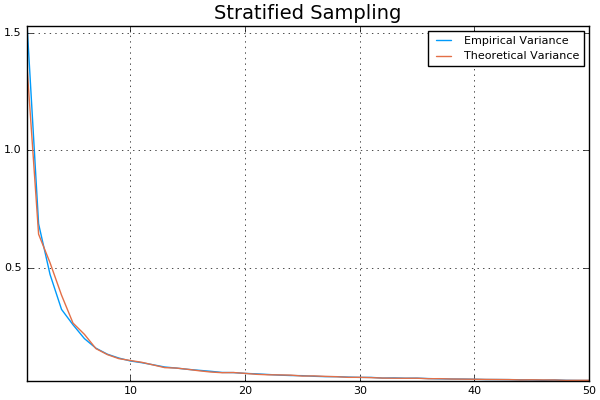

In [117]:
s = estimatorVar(stratified)
plot(1:50,s,label="Empirical Variance",title="Stratified Sampling")
plot!(1:50,strat_var,label="Theoretical Variance")

In [118]:
png("stratified_plot")

## Side-by-side comparison


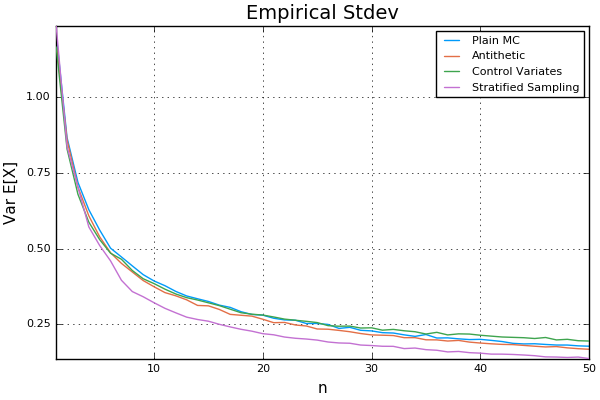

In [120]:
s = estimatorVar(plainMC)
plot(1:50,sqrt(s),label="Plain MC",xlabel="n",ylabel="Var E[X]",title="Empirical Stdev",size=(600,400))
s = estimatorVar(antithetic)
plot!(1:50,sqrt(s),label="Antithetic")
s = estimatorVar(controlvariates)
plot!(1:50,sqrt(s),label="Control Variates")
s = estimatorVar(stratified)
plot!(1:50,sqrt(s),label="Stratified Sampling")

In [121]:
png("comparison")